<h1><center> Blood cells classification </center></h1>



In [ ]:
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
from dask import diagnostics, bag
import seaborn as sns
from tensorflow import keras
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import cv2
import matplotlib.pylab as plt
import matplotlib.cm as cm
import os
import tensorflow.compat.v1 as tf
import itertools

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

# !pip install split-folders
# import splitfolders

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
dirpath = "/content/drive/MyDrive/Kaggle/PBC_dataset_normal_DIB/PBC_dataset_normal_DIB/"

# **Dataset I** : Peripheral blood cell

___________________basophil___________________


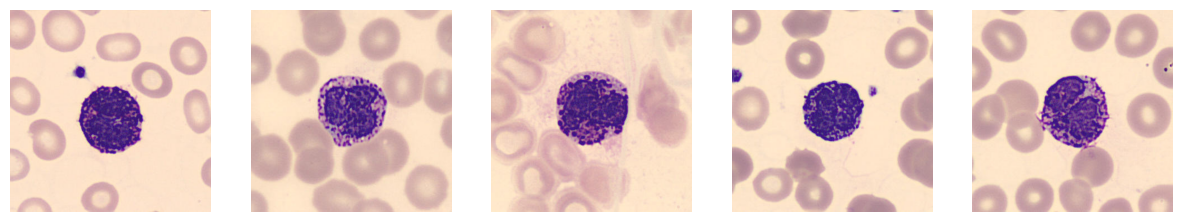

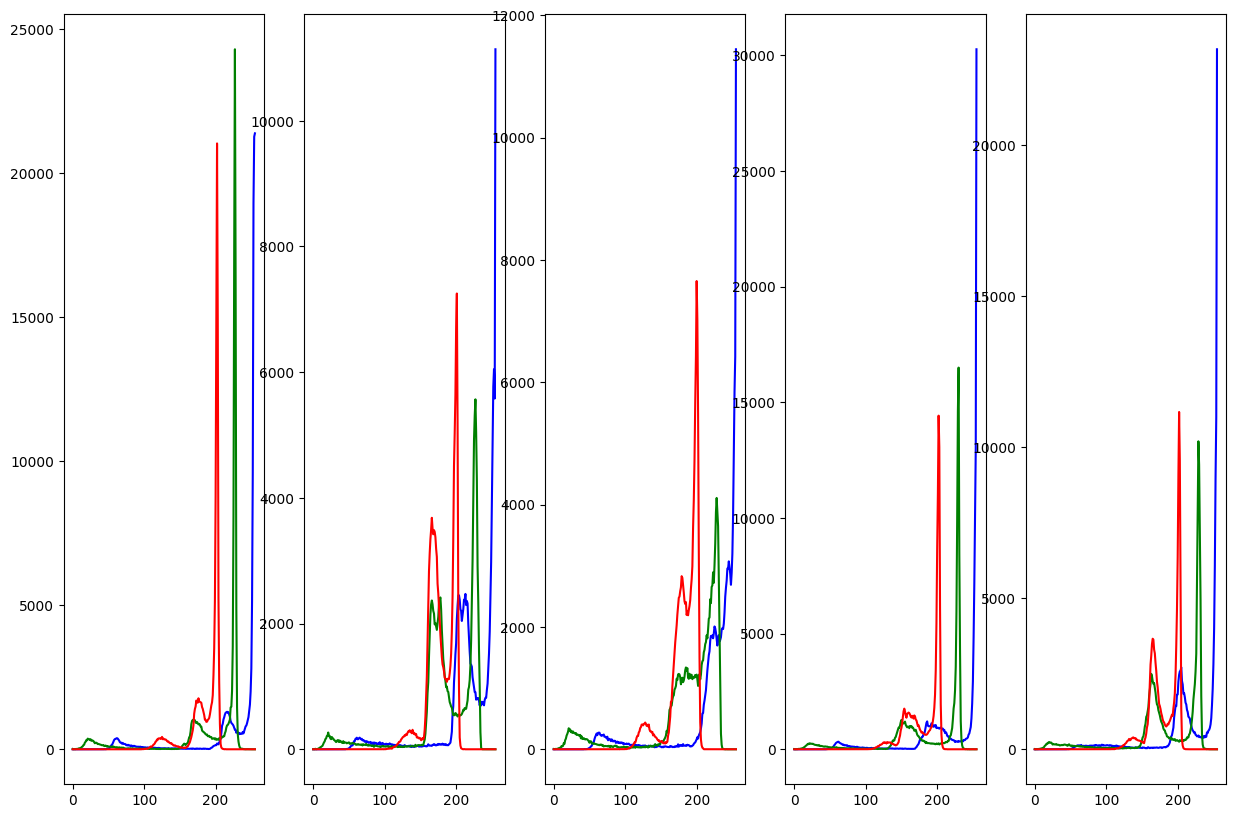

___________________eosinophil___________________


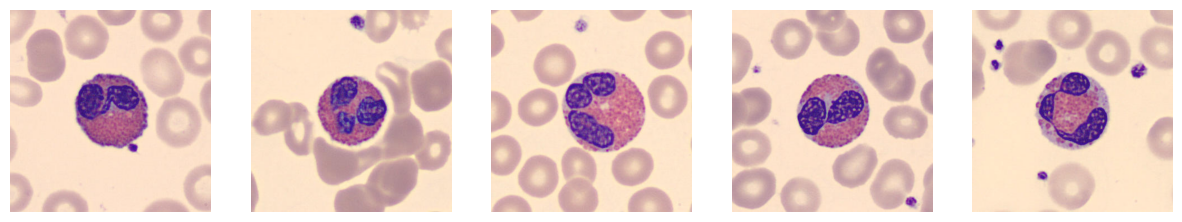

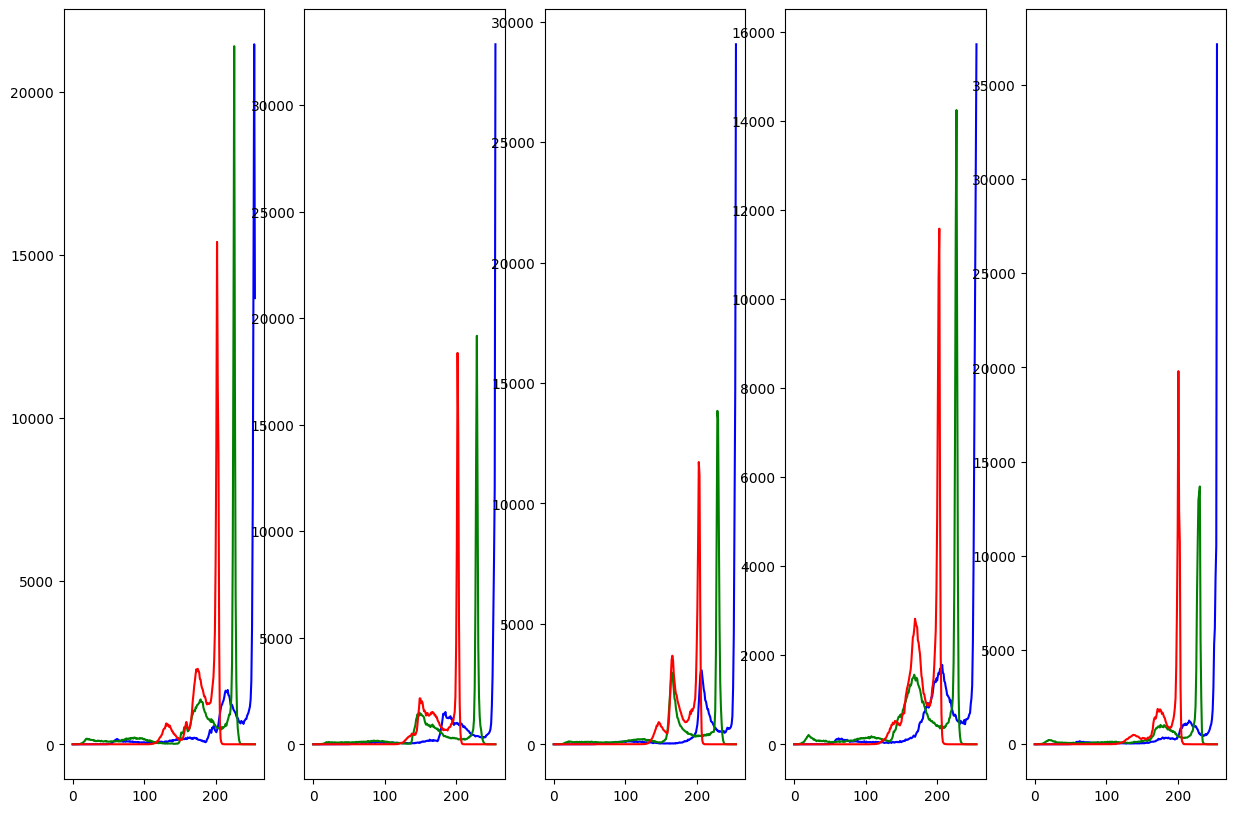

___________________ig___________________


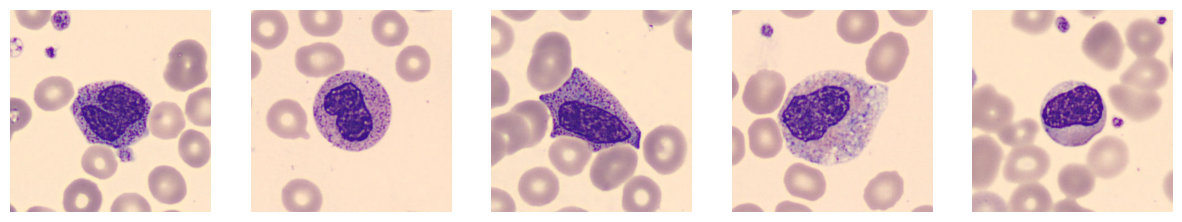

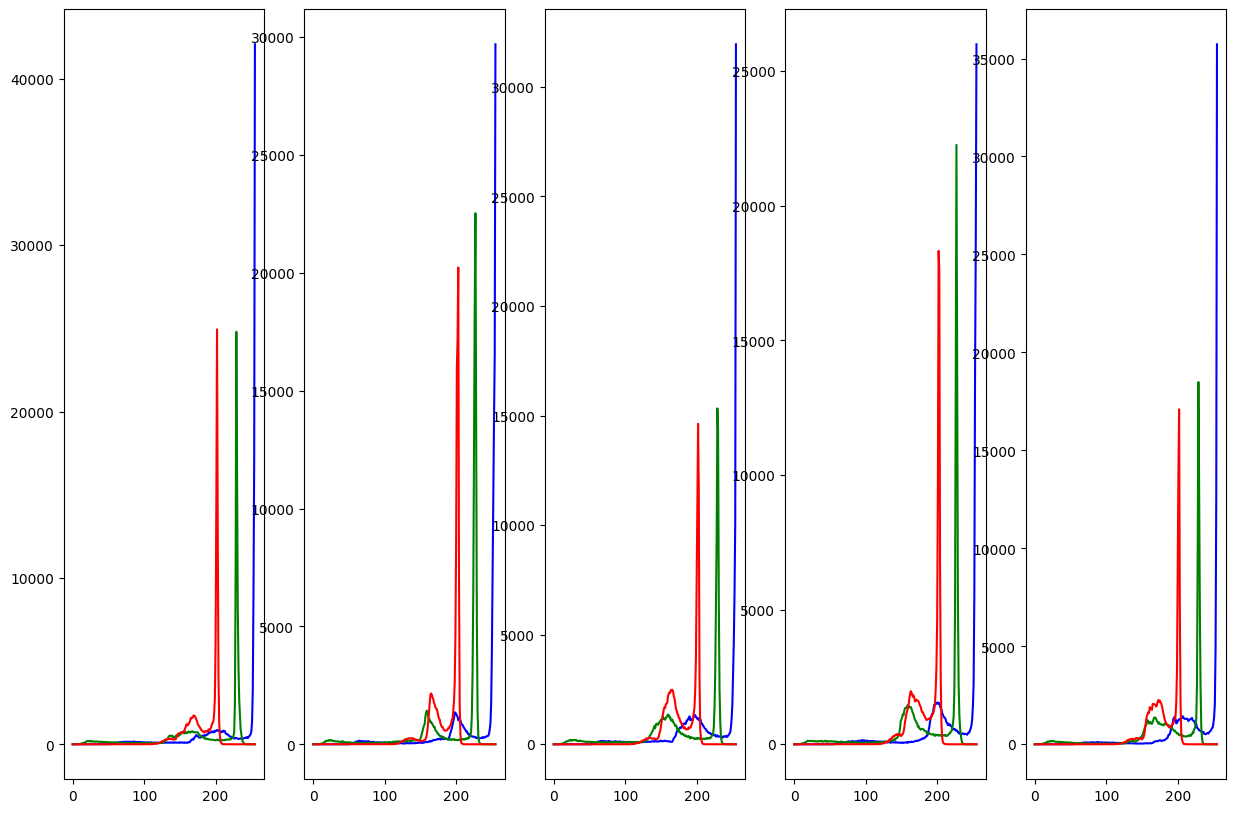

___________________lymphocyte___________________


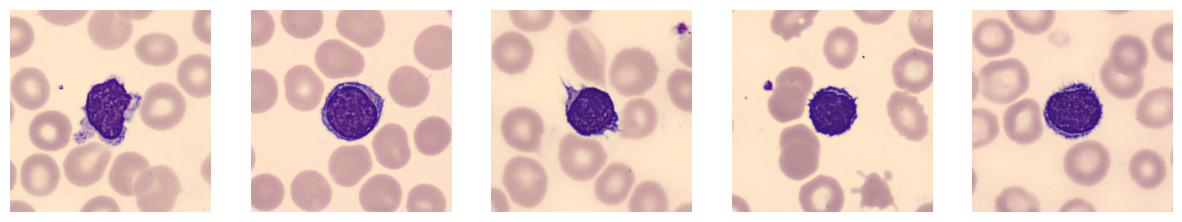

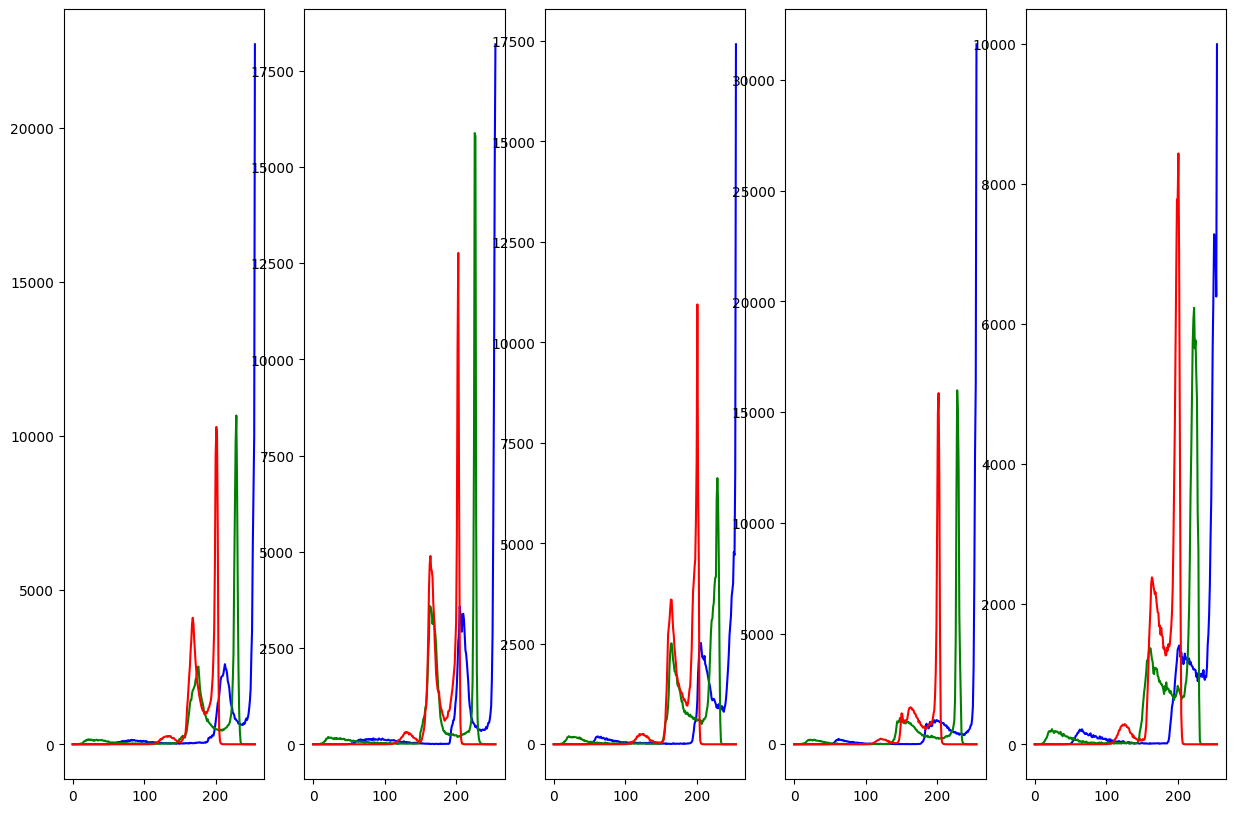

___________________monocyte___________________


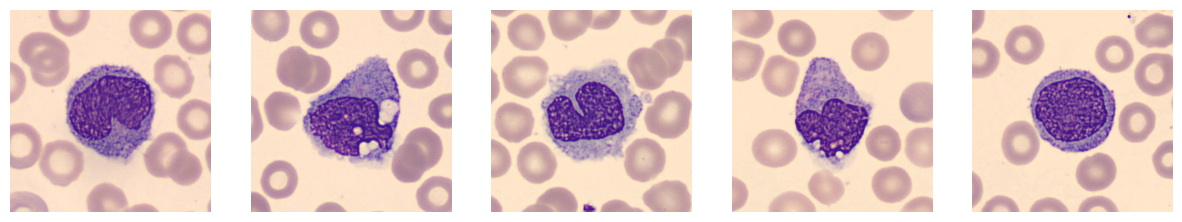

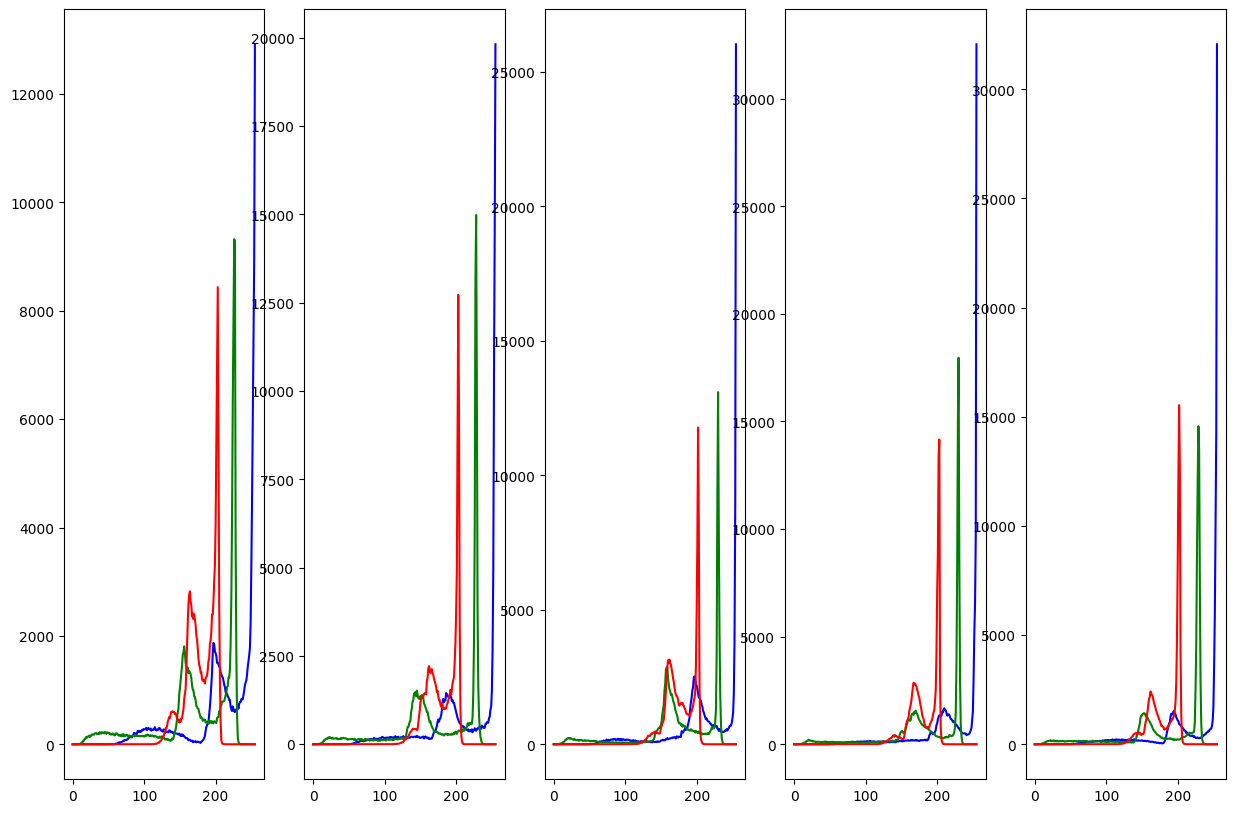

___________________neutrophil___________________


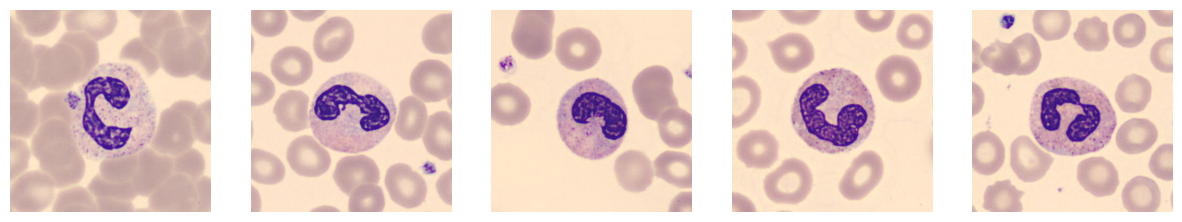

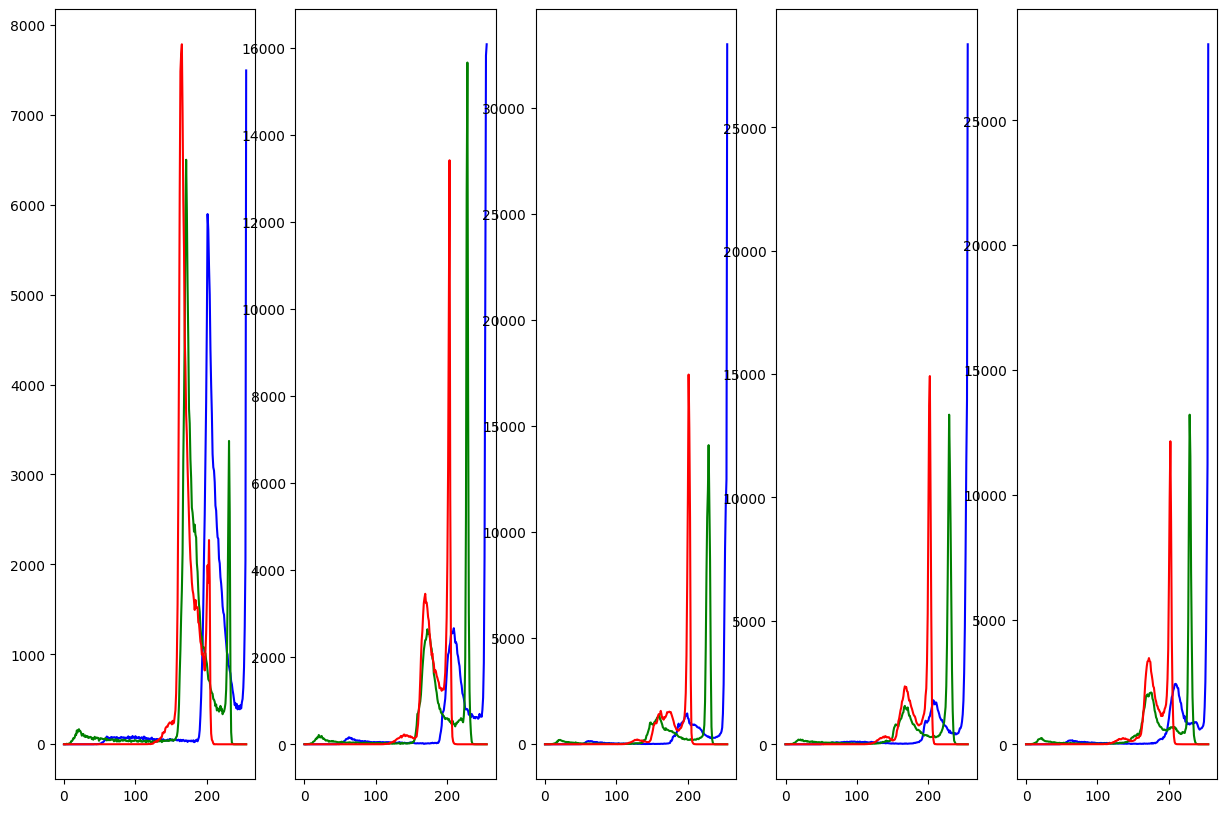

___________________platelet___________________


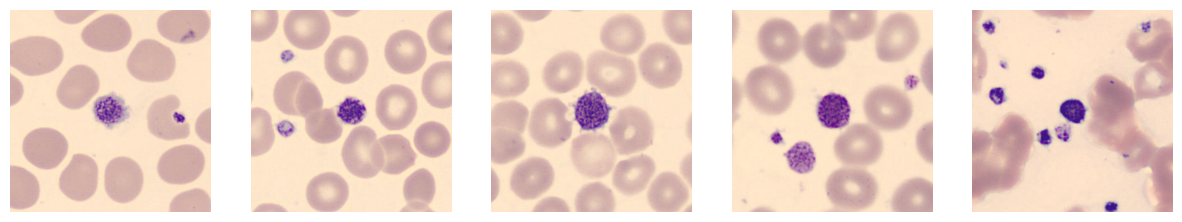

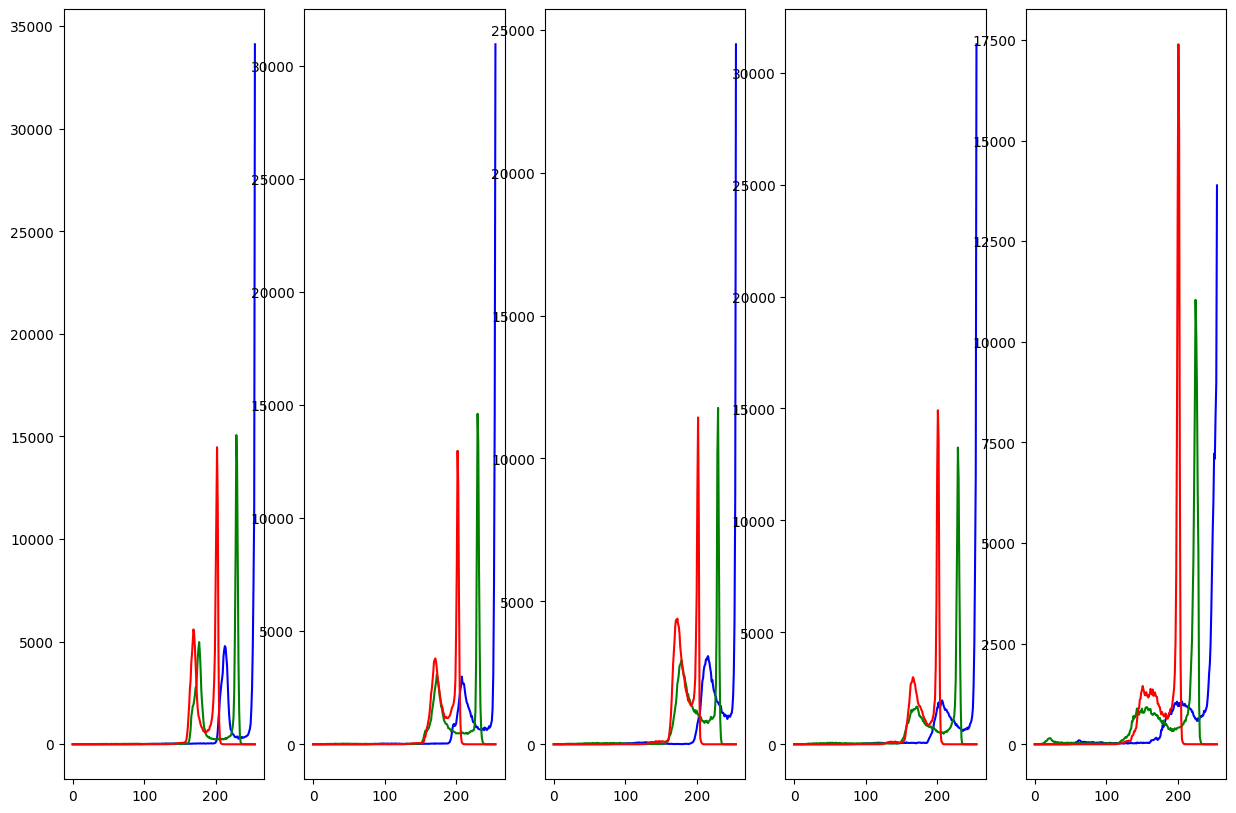

___________________erythroblast___________________


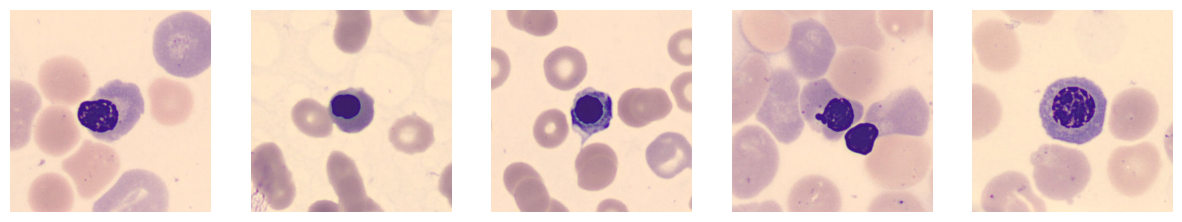

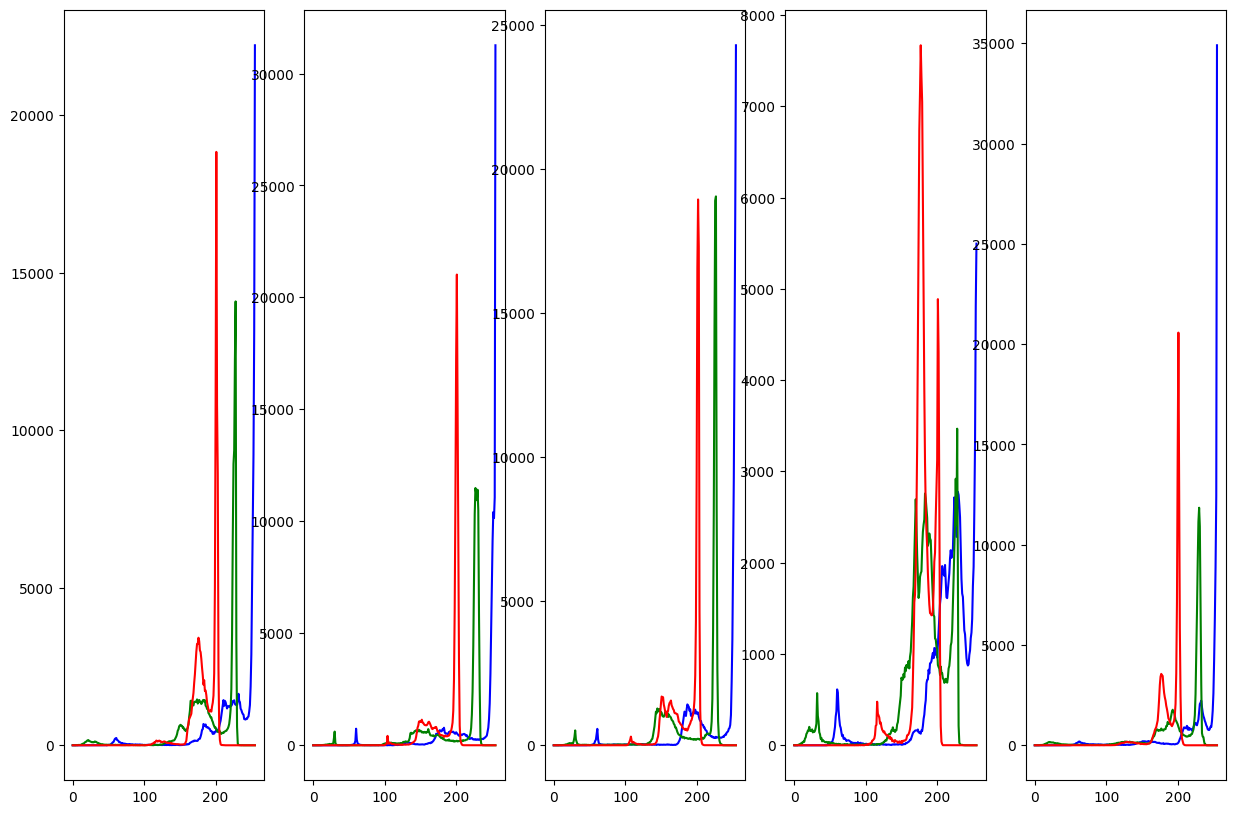

In [ ]:
def cels_plot(dirpath, nrows, ncols, rgb=False):
  """
  plot images for each class.
  parameters :
    dirpath : class directory.
    nrows : number of rows for image display grid
    ncols : number of columns for image display grid
    rgb   : (boolean) plot images histogram.
  """
  for i in os.listdir(dirpath):
    dp = os.path.join(dirpath, i)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    ax = ax.flatten()
    if rgb:
      fig2, ax2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
      ax2 = ax2.flatten()
    print(f"___________________{i}___________________")
    for j, im in enumerate(os.listdir(dp)):
      if j == nrows*ncols:
        break
      fp = os.path.join(dp, im)
      img = Image.open(fp)
      ax[j].imshow(img)
      ax[j].axis("off")
      if rgb:
        image = io.imread(fp)
        color = ('b','g','r')
        for k,col in enumerate(color):
            histr = cv2.calcHist([image],[k],None,[256],[0,256])
            ax2[j].plot(histr,color = col)
    plt.show();

cels_plot(dirpath=dirpath, nrows=1, ncols=5, rgb=True)

We have a total number of : 17092 images. 



<Figure size 640x480 with 0 Axes>

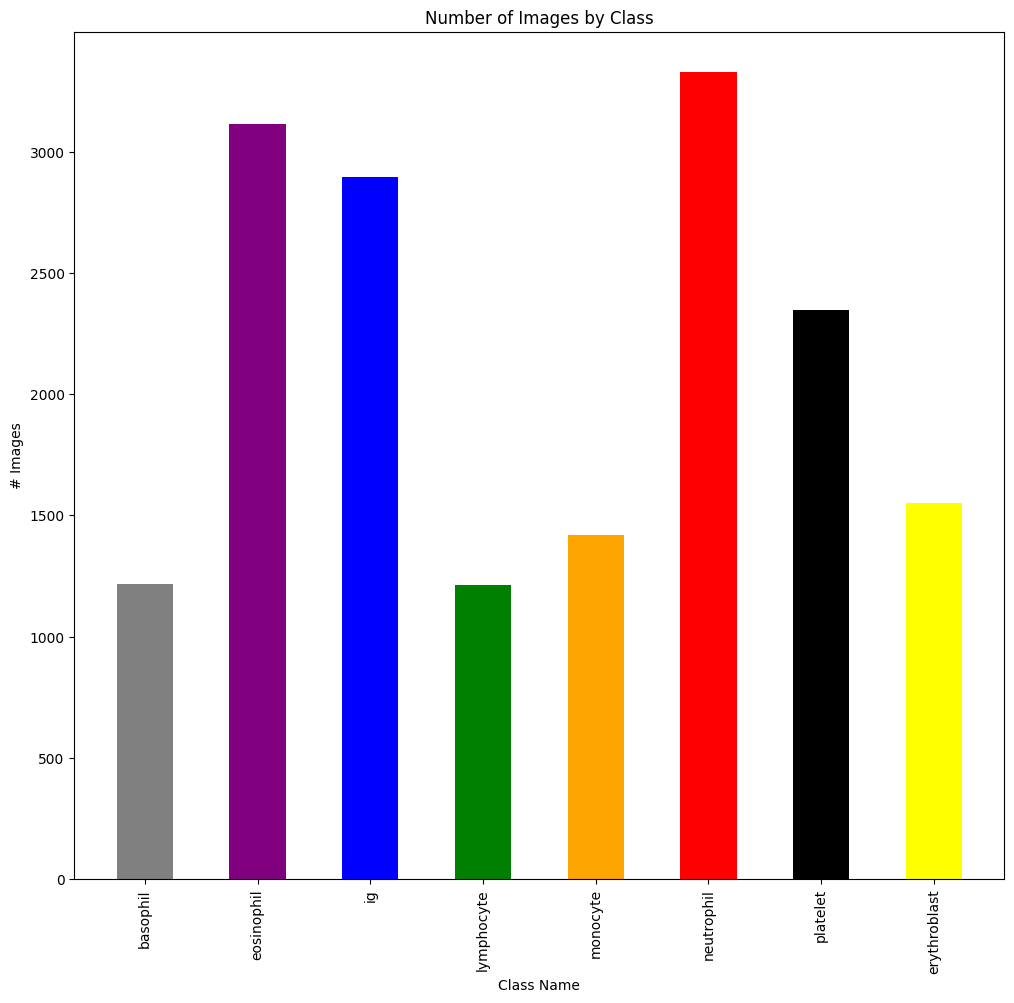

In [ ]:
number_classes = {i:len(os.listdir(dirpath + i)) for i in os.listdir(dirpath)}

print("We have a total number of :", sum(list(number_classes.values())), "images. \n")
fig = plt.figure()
fig.suptitle('test title', fontsize=60)
plt.figure(figsize=(12,11))
plt.title("Number of Images by Class")
plt.bar(number_classes.keys(), number_classes.values(), width = .5,
        color=['grey', 'purple', 'blue', 'green', 'orange', 'red', 'black', 'yellow'])
plt.xlabel('Class Name')
plt.ylabel('# Images')
plt.xticks(rotation ='vertical')
plt.savefig("distribution.png");

rm: cannot remove '/content/drive/MyDrive/Kaggle/PBC_dataset_normal_DIB/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg': No such file or directory
[########################################] | 100% Completed | 15.71 s


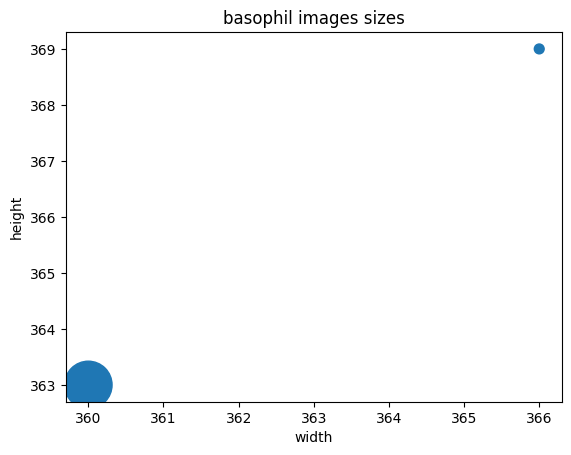

[########################################] | 100% Completed | 52.79 s


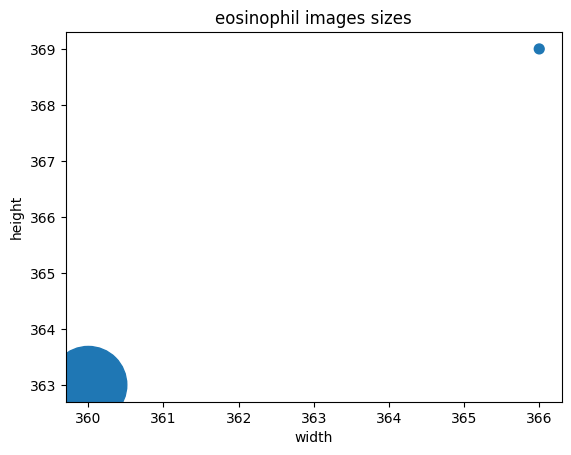

[########################################] | 100% Completed | 44.68 s


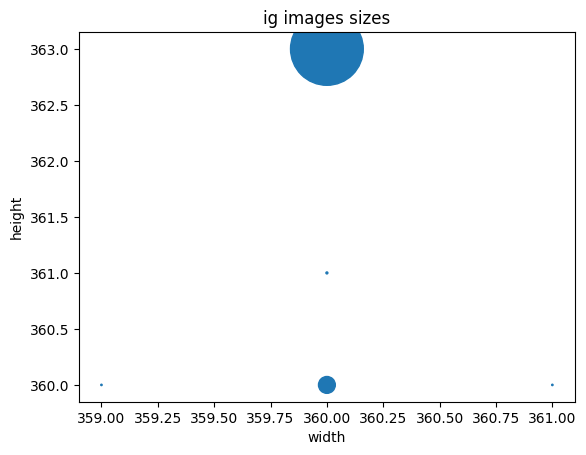

[########################################] | 100% Completed | 16.23 s


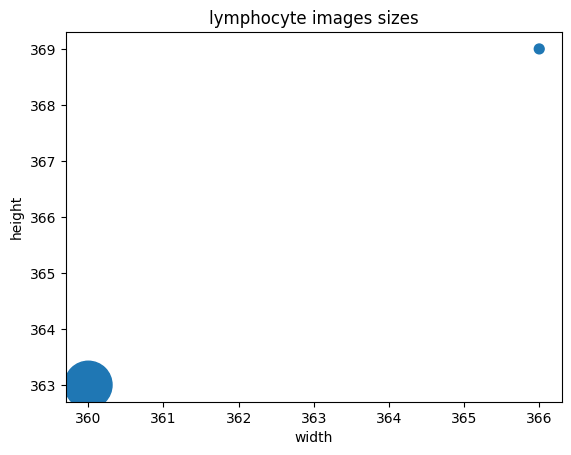

[########################################] | 100% Completed | 25.31 s


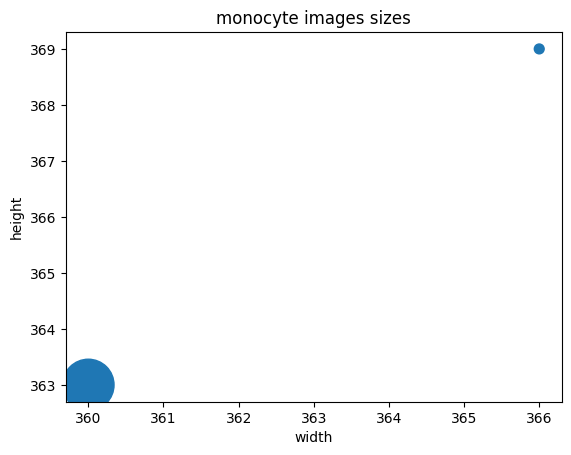

[########################################] | 100% Completed | 103.56 s


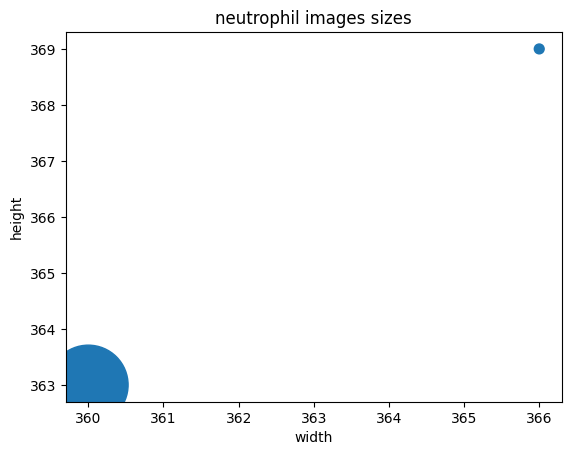

[########################################] | 100% Completed | 34.92 s


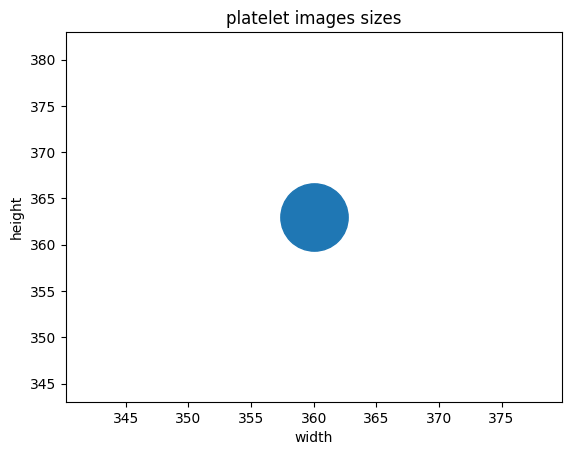

[########################################] | 100% Completed | 21.66 s


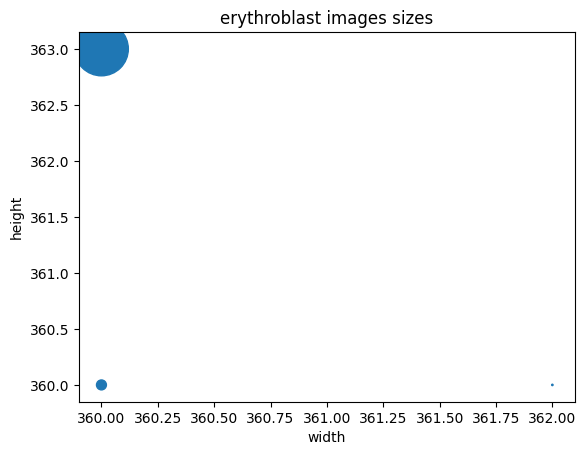

In [ ]:
directories = {i:f"{dirpath}{i}/" for i in os.listdir(dirpath)}

def get_dims(file):
  """
  get images dimensions
  parameters:
    file : image file
  return:
    tuple of file dimension
  """
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

# removal of corrupted files
!rm '/content/drive/MyDrive/Kaggle/PBC_dataset_normal_DIB/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg'

problem    = []
for n,d in directories.items():
  # try:
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
      dims = dims.compute()
      dim_df = pd.DataFrame(dims, columns=['height', 'width'])
      sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
      sizes.plot.scatter(x='width', y='height', s=sizes["count"]);
      plt.title('{} images sizes'.format(n))
    plt.show();
#   except :
#     pass
#     problem.append(n)

# print("directory with problems is :", problem)

# **Dataset II**: Acute Promyelocytic Leukemia

In [ ]:
path = "/content/drive/MyDrive/Kaggle/leukemia_data/All/All"
no_correctDir = []
for i in os.listdir(path):
  try:
    os.listdir(path+f"/{i}/Signed slides")
  except:
    pass
    no_correctDir.append(i)

print(f"\nThere are {len(no_correctDir)} files to correct: \n", no_correctDir)


There are 11 files to correct: 
 ['Patient_100', 'Patient_32', 'Patient_39', 'Patient_59', 'Patient_60', 'Patient_69', 'Patient_73', 'Patient_80', 'Patient_81', 'Patient_79', 'Patient_84']


___Patient_00___
65 images :
{'Blast, no lineage spec': 7, 'Lymphocyte': 27, 'Lymphocyte, variant': 3, 'Smudge cells': 5, 'Erythroblast': 4, 'Giant thrombocyte': 2, 'Eosinophils': 3, 'Promyelocyte': 2, 'Segmented neutrophils': 12}


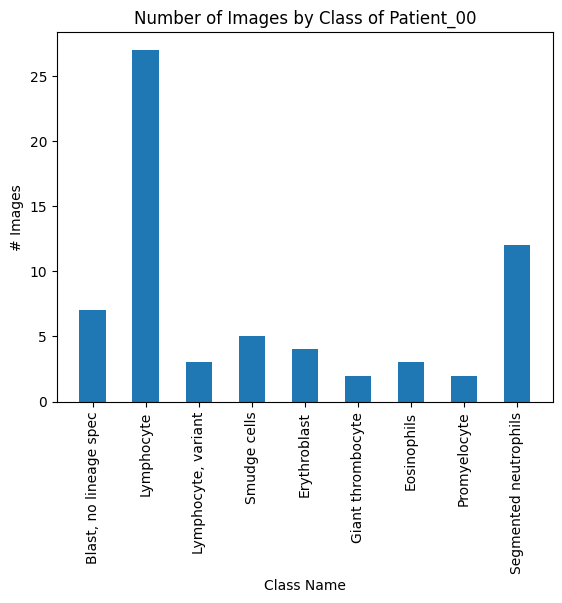

___Patient_07___
131 images :
{'Basophil': 1, 'Blast, no lineage spec': 7, 'Monocyte': 54, 'Erythroblast': 7, 'Segmented neutrophils': 34, 'Band neutrophils': 4, 'Metamyelocyte': 1, 'Promyelocyte': 2, 'Lymphocyte': 6, 'Smudge cells': 15}


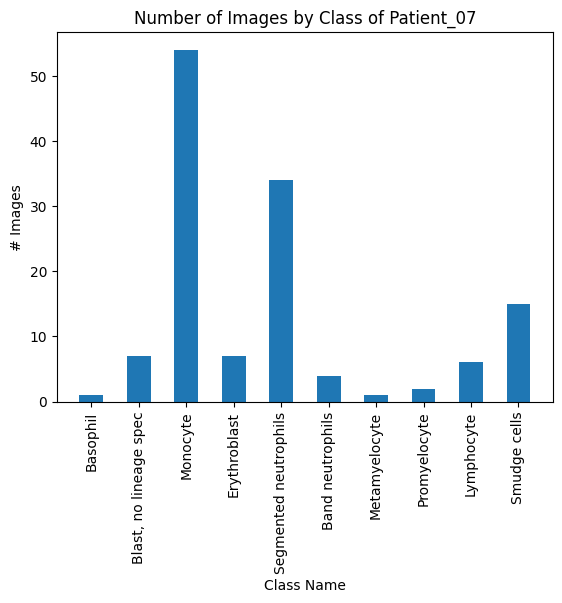

___Patient_03___
125 images :
{'Smudge cells': 15, 'Segmented neutrophils': 6, 'Monocyte': 37, 'Lymphocyte, variant': 1, 'Basophil': 3, 'Lymphocyte': 34, 'Blast, no lineage spec': 29}


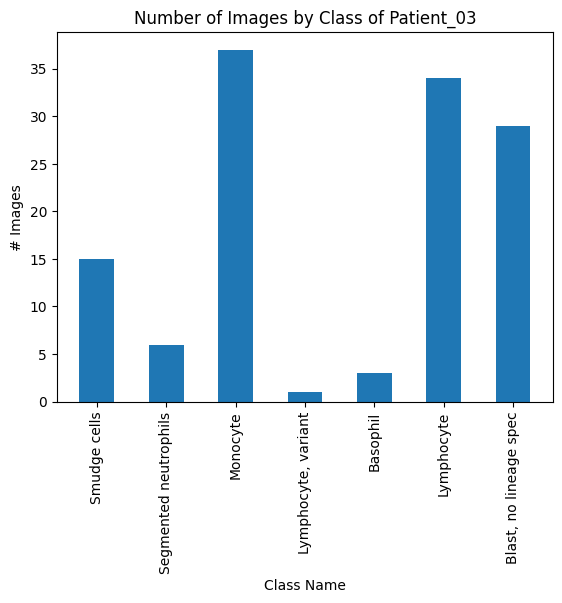

___Patient_04___
140 images :
{'Segmented neutrophils': 1, 'Lymphocyte': 33, 'Blast, no lineage spec': 94, 'Lymphocyte, variant': 3, 'Smudge cells': 9}


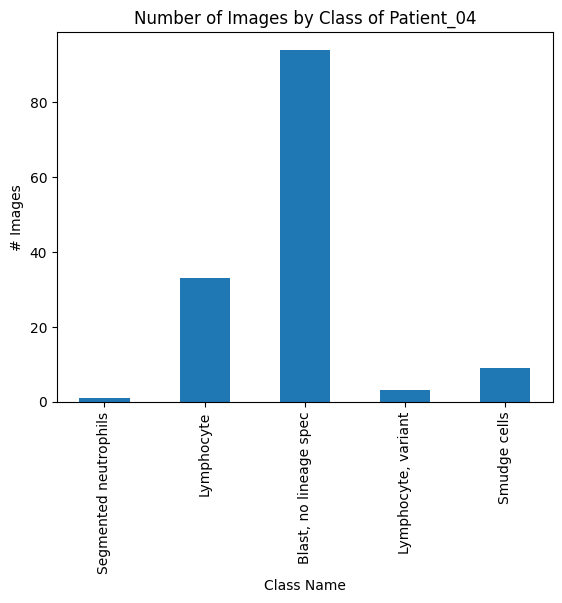

___Patient_05___
153 images :
{'Metamyelocyte': 2, 'Segmented neutrophils': 25, 'Eosinophils': 1, 'Lymphocyte': 26, 'Blast, no lineage spec': 26, 'Smudge cells': 17, 'Monocyte': 4, 'Lymphocyte, variant': 7, 'Erythroblast': 36, 'Myelocyte': 9}


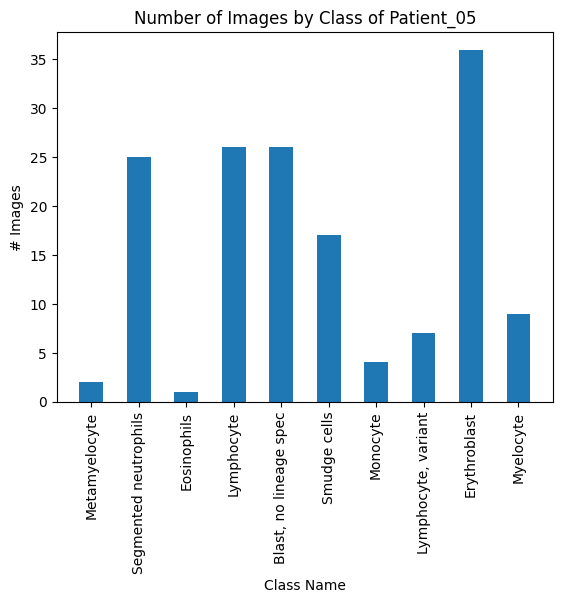

___Patient_08___
168 images :
{'Lymphocyte': 7, 'Lymphocyte, variant': 2, 'Blast, no lineage spec': 30, 'Promyelocyte': 29, 'Giant thrombocyte': 2, 'Monocyte': 33, 'Eosinophils': 5, 'Myelocyte': 2, 'Smudge cells': 52, 'Band neutrophils': 6}


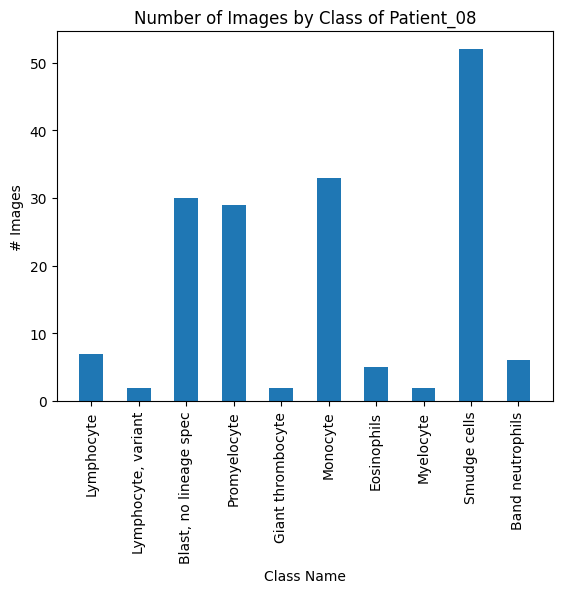

___Patient_02___
126 images :
{'Lymphocyte': 34, 'Monocyte': 54, 'Basophil': 1, 'Lymphocyte, variant': 4, 'Blast, no lineage spec': 10, 'Segmented neutrophils': 10, 'Giant thrombocyte': 1, 'Smudge cells': 12}


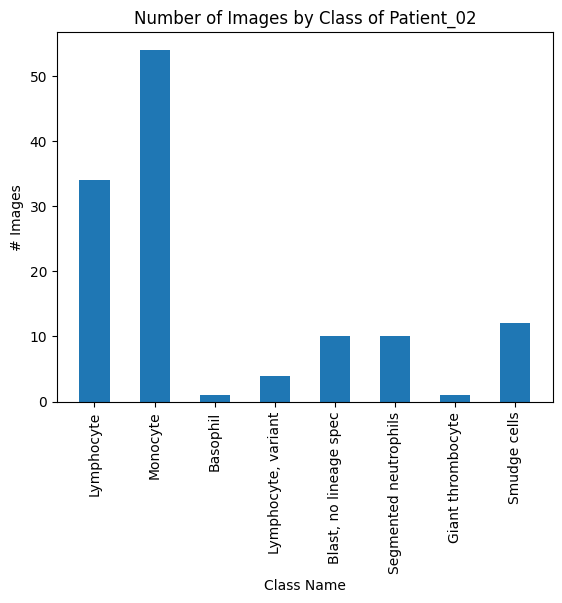

___Patient_06___
141 images :
{'Smudge cells': 31, 'Eosinophils': 2, 'Erythroblast': 1, 'Blast, no lineage spec': 43, 'Lymphocyte, variant': 22, 'Lymphocyte': 36, 'Band neutrophils': 1, 'Metamyelocyte': 1, 'Segmented neutrophils': 4}


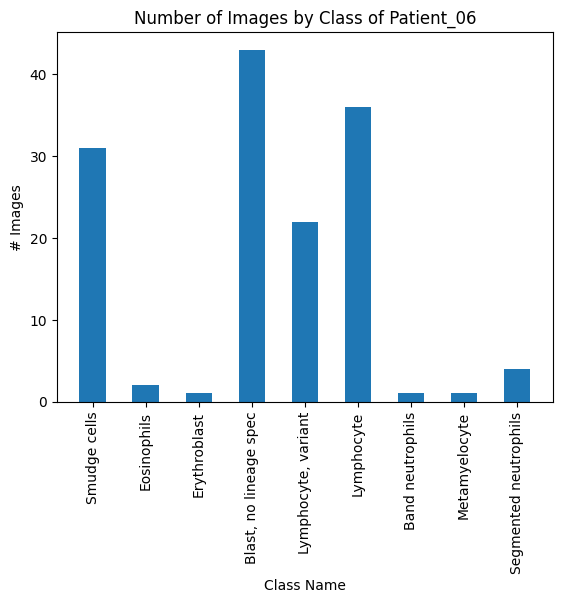

___Patient_01___
140 images :
{'Erythroblast': 6, 'Smudge cells': 14, 'Lymphocyte': 38, 'Monocyte': 2, 'Segmented neutrophils': 48, 'Lymphocyte, variant': 4, 'Blast, no lineage spec': 28}


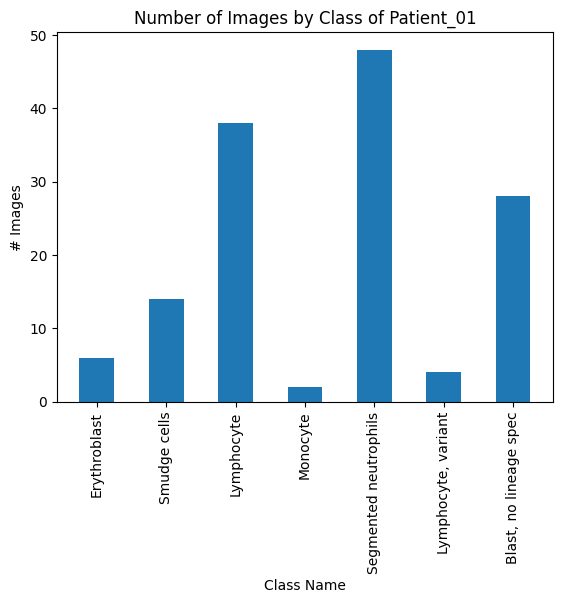

___Patient_11___
123 images :
{'Blast, no lineage spec': 34, 'Erythroblast': 1, 'Smudge cells': 9, 'Segmented neutrophils': 2, 'Monocyte': 5, 'Lymphocyte': 72}


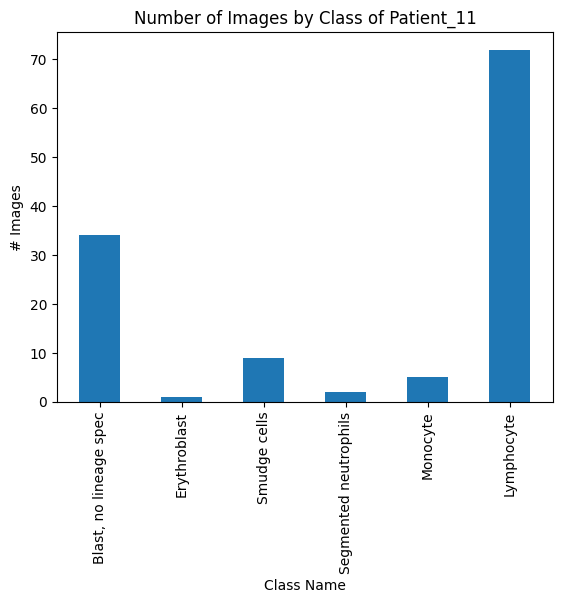

___Patient_103___
112 images :
{'Smudge cells': 3, 'Band neutrophils': 5, 'Segmented neutrophils': 20, 'Lymphocyte, variant': 9, 'Thrombocyte aggregation': 2, 'Erythroblast': 41, 'Plasma cells': 2, 'Monocyte': 2, 'Eosinophils': 4, 'Lymphocyte': 24}


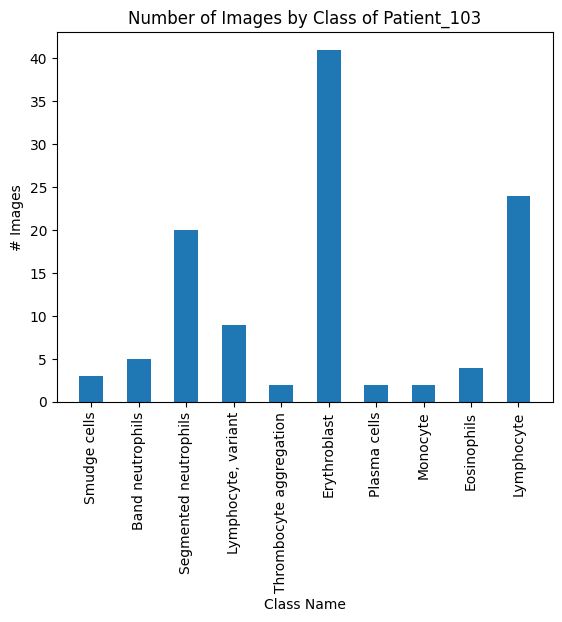

___Patient_09___
112 images :
{'Lymphocyte': 27, 'Plasma cells': 2, 'Blast, no lineage spec': 9, 'Segmented neutrophils': 4, 'Basophil': 3, 'Smudge cells': 5, 'Lymphocyte, variant': 1, 'Metamyelocyte': 2, 'Promonocyte': 12, 'Monocyte': 47}


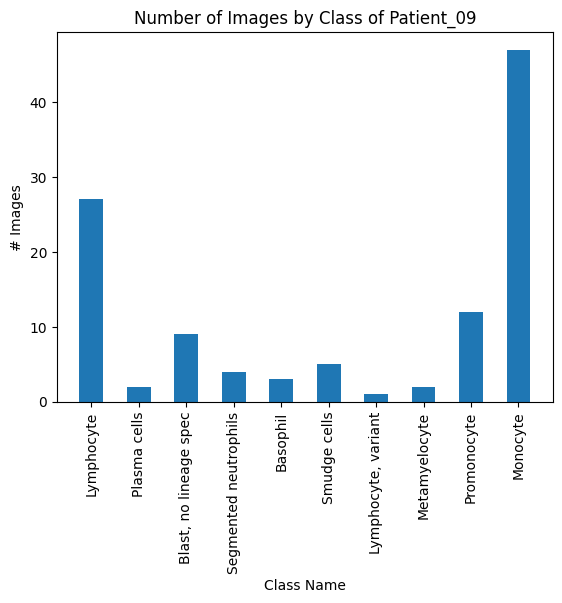

___Patient_105___
143 images :
{'Blast, no lineage spec': 16, 'Lymphocyte, variant': 11, 'Band neutrophils': 3, 'Segmented neutrophils': 21, 'Promyelocyte': 9, 'Basophil': 1, 'Smudge cells': 39, 'Lymphocyte': 43}


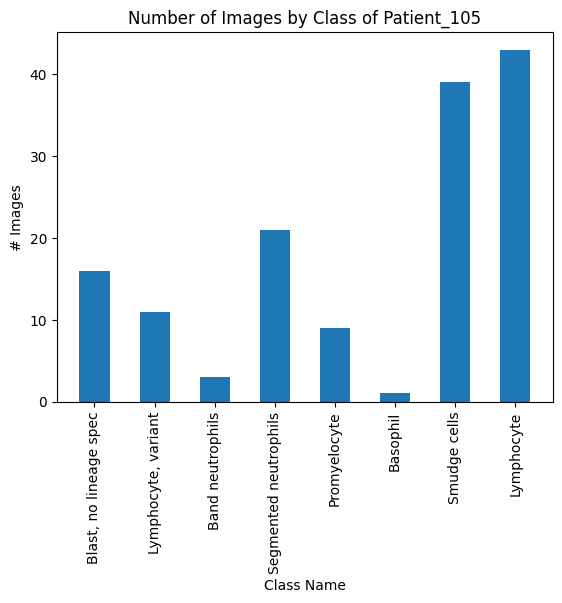

___Patient_10___
147 images :
{'Promyelocyte': 21, 'Lymphocyte': 5, 'Blast, no lineage spec': 50, 'Segmented neutrophils': 6, 'Monocyte': 18, 'Smudge cells': 36, 'Band neutrophils': 4, 'Lymphocyte, variant': 7}


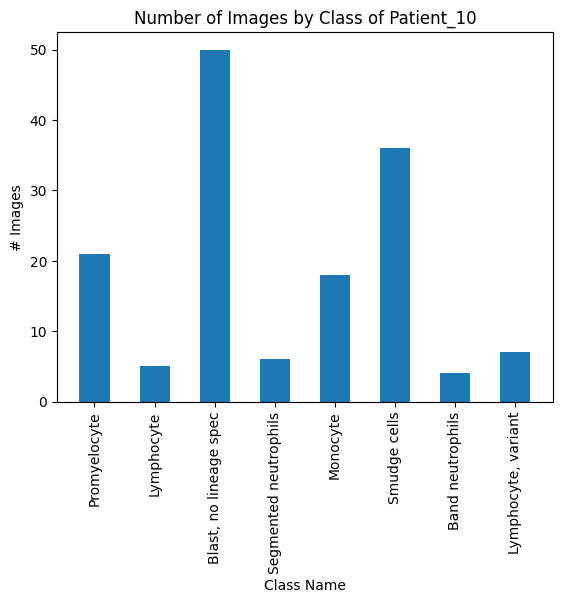

#####################################################################


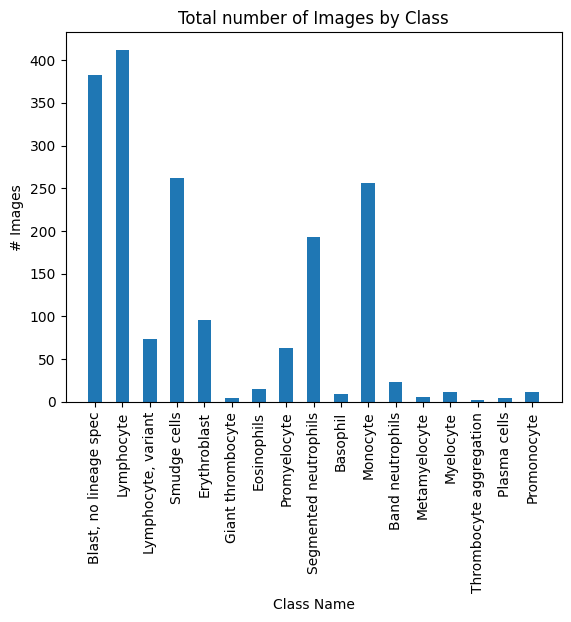

In [ ]:
def print_img_dist(path, plot=True, stat=False, grouped_plot=True):
  """
  Print image distribution and some statistics

  Parameters :
    path : directory path.
    plot : print the number of image by class and by patient.
    stat : boolean for print classes frequences by patient.
    grouped_plot : boolean, if true, plot number of image by class.
  """
  total = {}
  try:
    for i in os.listdir(path):
      nb = {}
      total_nb_img = []
      for j in os.listdir(path+f"/{i}/Signed slides"):
        Len = len(os.listdir(path+f"/{i}/Signed slides/"+j))
        if j in total.keys():
          total[j] += Len
        else:
          total[j] = Len
        nb.update({j:Len})
      if stat:
        print(f"___{i}___")
        print(sum(list(nb.values())), "images :")
        print(nb)
      if plot:
        plt.title(f"Number of Images by Class of {i}")
        plt.bar(nb.keys(), nb.values(), width = .5)
        plt.xlabel('Class Name')
        plt.ylabel('# Images')
        plt.xticks(rotation ='vertical')
        plt.show();
  except:
    pass
  if grouped_plot:
    print("#####################################################################")
    plt.title(f"Total number of Images by Class")
    plt.bar(total.keys(), total.values(), width = .5)
    plt.xlabel('Class Name')
    plt.ylabel('# Images')
    plt.xticks(rotation ='vertical')
    plt.show();

print_img_dist(path=path, plot=True, stat=True, grouped_plot=True)